In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np
import math

import mahotas as mh
import cv2
from PIL import Image

import copy, os

from skimage import io, exposure
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.draw import disk as pdisk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_otsu, threshold_multiotsu, rank
from skimage.filters import sobel

from scipy.stats import skew
from scipy.signal import argrelextrema


In [2]:
scan_path_root = "/mnt/ula/catfish/test_scans/"

dapi_suffix = "/1.tif"
overlay_suffix = "/overlay.tif"

In [3]:
class Nucleus(): 
    def __init__(self, nucelusProps, approxEllipse,  idno):
        self.nucelusProps = nucelusProps
        self.approxEllipse = approxEllipse
        self.idno = idno

In [4]:
def divide_region_approx_ellipse(region, last_id):
    new_nuclei = np.array([])
    alpha = (-180/math.pi)*(region.orientation)
    shift_x = 0.25*region.major_axis_length*math.sin(math.radians(-alpha))
    shift_y = 0.25*region.major_axis_length*math.cos(math.radians(-alpha))
    approxEllipse = mpatches.Ellipse((region.centroid[1]-shift_x,region.centroid[0]-shift_y), region.minor_axis_length,
                                                             region.major_axis_length/2,alpha,
                           fill=False, edgecolor='red', linewidth=1)  
    new_nucleus = Nucleus(region, copy.copy(approxEllipse), last_id)
    
    new_nuclei = np.append(new_nuclei, new_nucleus) 
                
    approxEllipse = mpatches.Ellipse((region.centroid[1]+shift_x,region.centroid[0]+shift_y), 
                                                 region.minor_axis_length,
                                                             region.major_axis_length/2,alpha,
                           fill=False, edgecolor='red', linewidth=1)  
    new_nucleus = Nucleus(region, copy.copy(approxEllipse), last_id+1)
    new_nuclei = np.append(new_nuclei, new_nucleus)
    return new_nuclei

In [5]:
def prepare_region_approximation(region, last_id):
    alpha = (-180/math.pi)*(region.orientation)
    if region.minor_axis_length == 0:
        ax_ratio = 0
    else:
        ax_ratio = region.major_axis_length/region.minor_axis_length
    new_nuclei = np.array([])
    #suwak + histogram do ustalania tej wartości?
    if ax_ratio * region.area > 1500:
        new_nuclei = divide_region_approx_ellipse(region, last_id)
    else:
        approxEllipse = mpatches.Ellipse((region.centroid[1],region.centroid[0]), region.minor_axis_length,
                                                             region.major_axis_length,alpha,
                           fill=False, edgecolor='red', linewidth=1)  
        new_nuclei = np.append(new_nuclei, Nucleus(region, copy.copy(approxEllipse), last_id))

    
    return new_nuclei

In [6]:
def dapi_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    ratio_thre = 1.6
    
    image_ts_orig = copy.copy(image_ts)
    
    image_ts = opening(image_ts, disk(2))
    

    thresh = threshold_otsu(image_ts[image_ts>0])/2
    

    local_thresh = threshold_local(image_ts, thresh_range, offset=0)
    binary_local = image_ts > local_thresh

    
    local_masked_global = np.ma.masked_array(data = binary_local, 
                                             mask = ~(image_ts > thresh), fill_value = 0).filled()

    local_masked_global = opening(local_masked_global, disk(5))
    elev_map = sobel(mh.gaussian_filter(image_ts,3))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]
   
    labels = watershed(-elev_map, markers, mask=local_masked_global)
    label_image = label(labels, connectivity = 1)

    areas = np.array([])
    intensities = np.array([])
    ellipse_axes_ratios = np.array([])
    
    for region in regionprops(label_image, intensity_image=image_ts):
        areas = np.append(areas, region.area)
        intensities = np.append(intensities, region.mean_intensity)
        if region.minor_axis_length == 0:
            ax_ratio = 0
        else:
            ax_ratio = region.major_axis_length/region.minor_axis_length
        ellipse_axes_ratios = np.append(ellipse_axes_ratios, ax_ratio)

    nuclei = np.array([])
    for region in regionprops(label_image):
        #tu threshold do premyślenia
        if region.area > 10:
            new_nuclei = prepare_region_approximation(region, len(nuclei))
        nuclei = np.append(nuclei, new_nuclei)   

    
    return nuclei, ellipse_axes_ratios, areas, intensities

In [9]:
def save_nuclei_overlay(dapi_img, nuclei, fig_path):
    ax = plt.subplot(aspect='equal')
    plt.imshow(dapi_img)
    for nuc in nuclei:
        ax.add_artist(nuc.approxEllipse)
    figure = plt.gcf() # get current figure
    figure.set_size_inches(dapi_img.shape[1]/100, dapi_img.shape[0]/100)
    plt.savefig(fig_path, dpi=100)
    plt.clf()

/home/ula/catfish/test_scans/CA1_left_glass_1_rat_2_hipp_left_skan_2019-10-08_105903


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


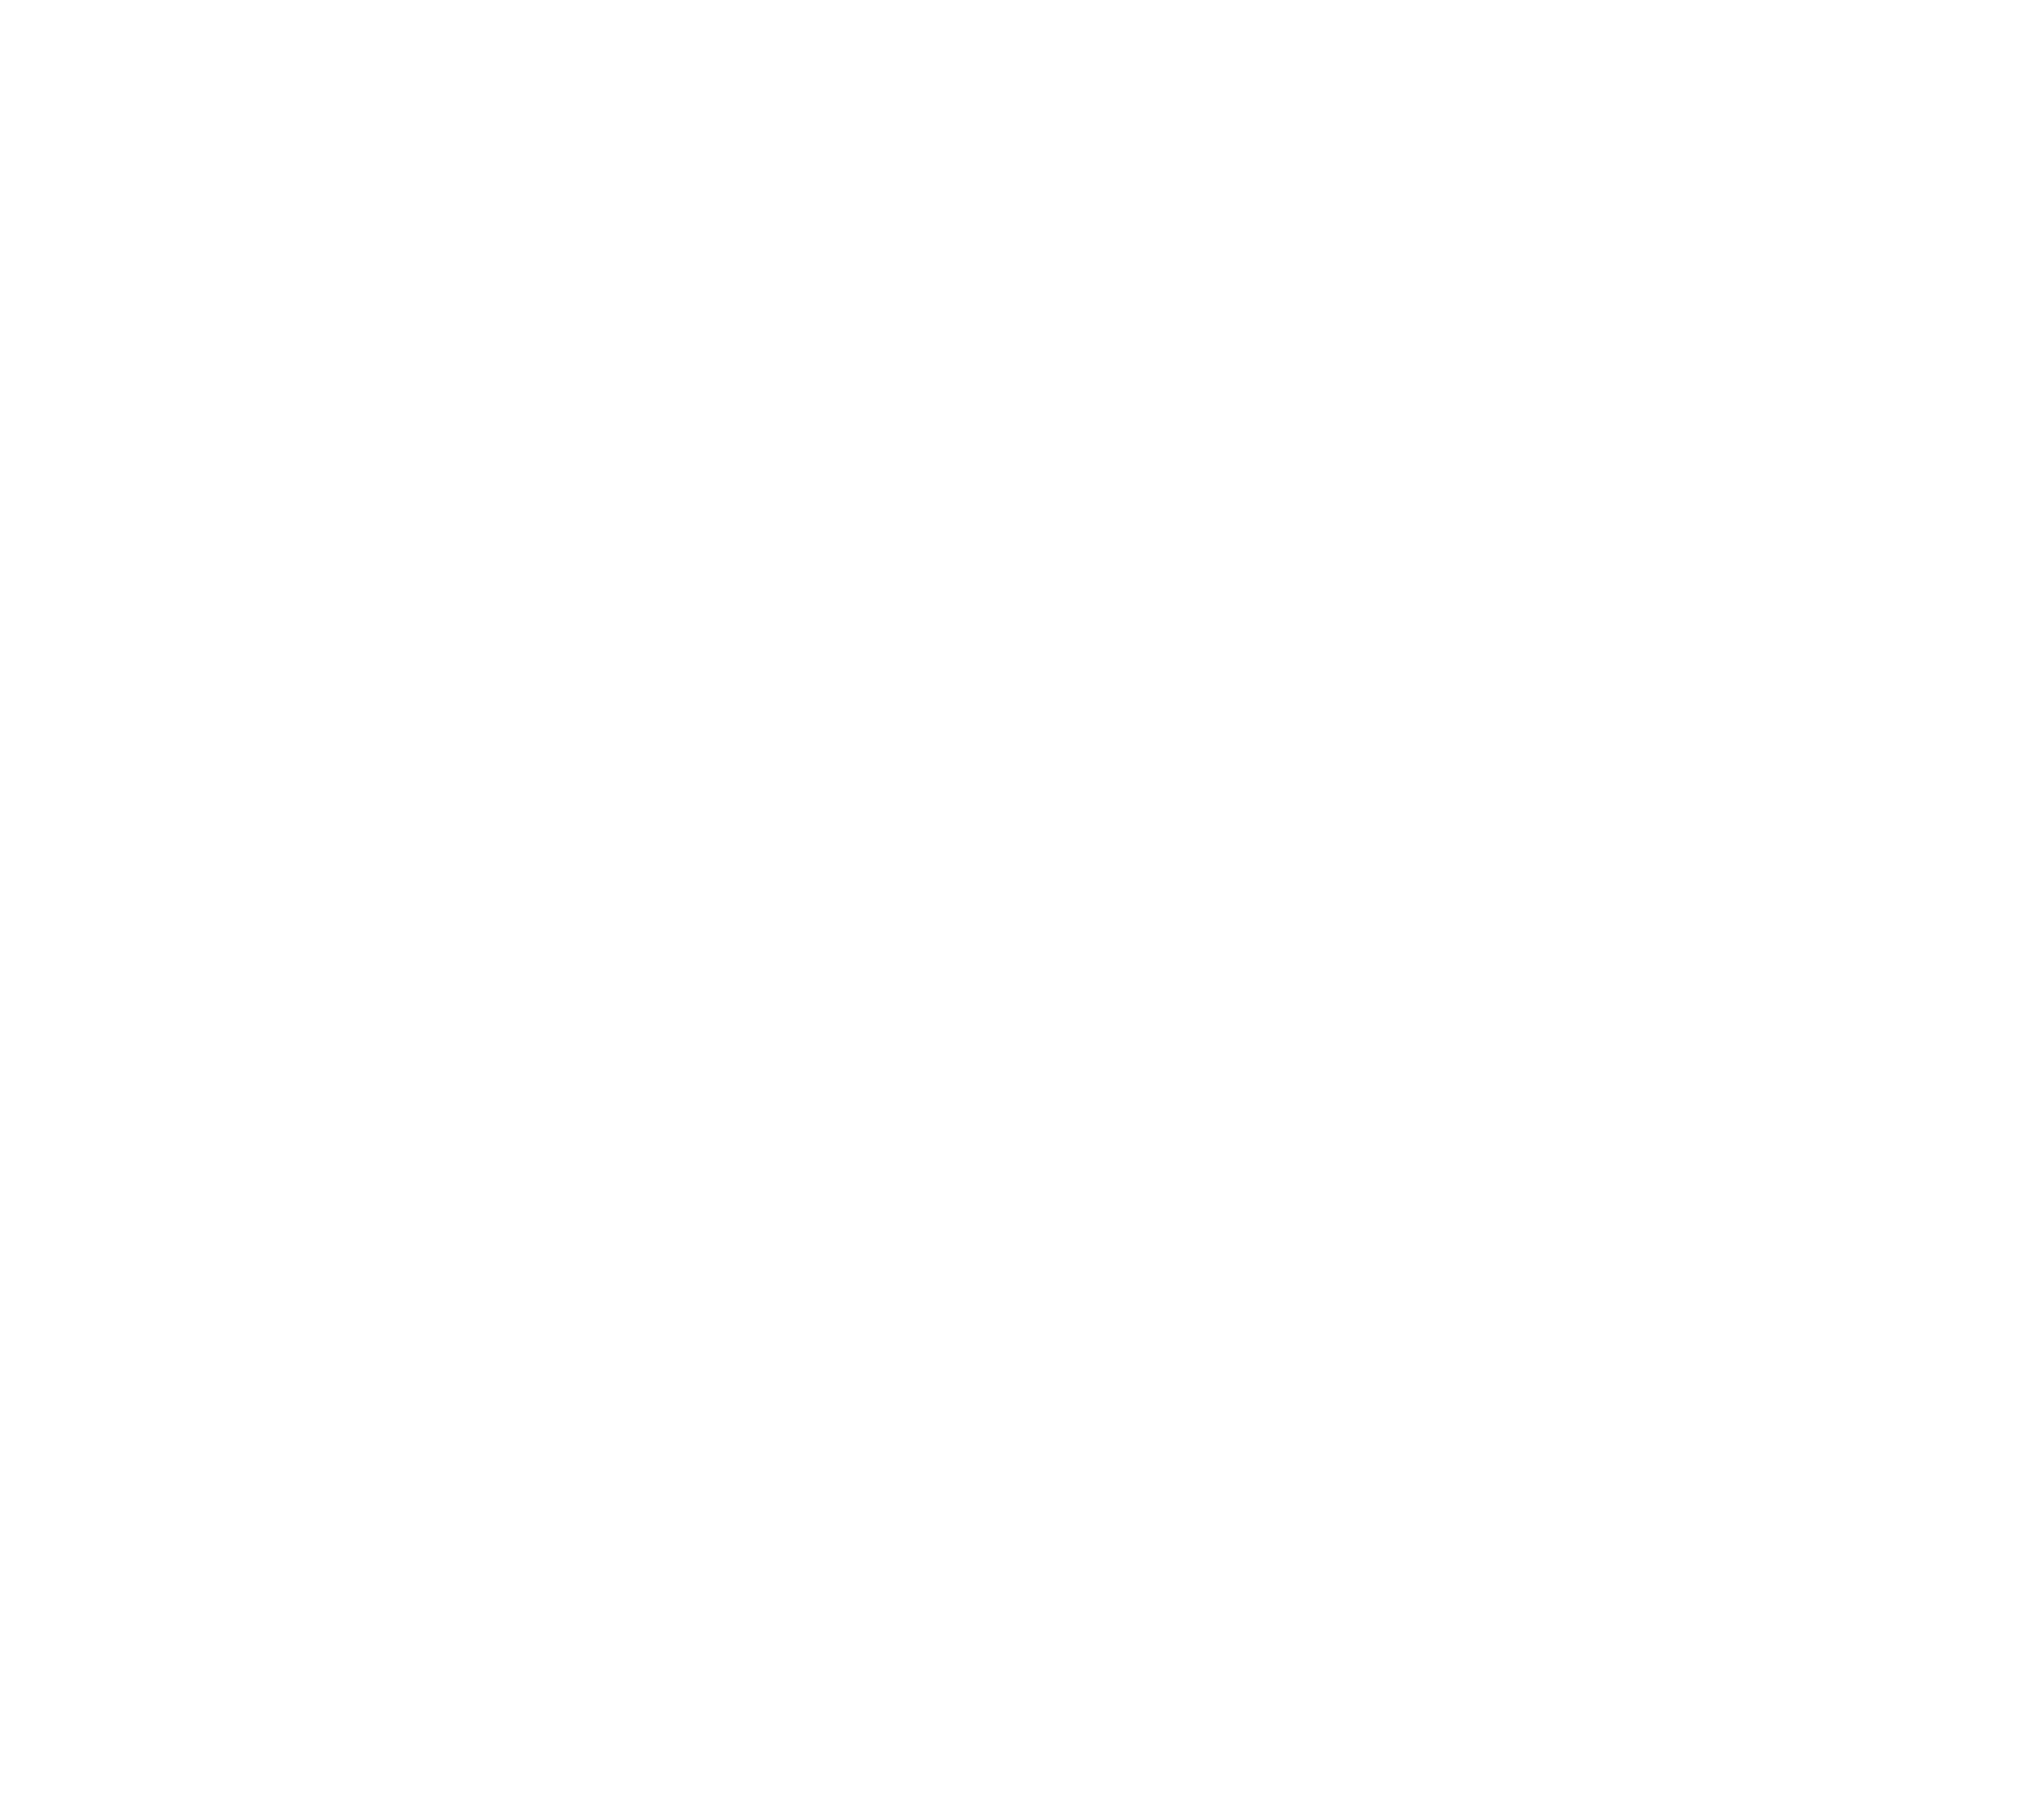

/home/ula/catfish/test_scans/Amyg_CE_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/CA1_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/CA3_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/RSD_right_glass_23_rat_20_rsd_rsgc_right_skan_2019-10-28_103719


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/Amyg_LA_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/DG_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/RSGc_right_glass_23_rat_20_rsd_rsgc_right_skan_2019-10-28_103719


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/Amyg_BLA_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [10]:
#MAIN loop to walk through img folder, looking for FOLDERS
scan_path_root = "/home/ula/catfish/test_scans/"


for filename in os.listdir(scan_path_root):
    if os.path.isdir(scan_path_root + filename):
        print(scan_path_root + filename)
        dapi_path = scan_path_root + filename + dapi_suffix
        dapi_img = io.imread(dapi_path)
        nuclei, ellipse_axes_ratios, areas, intensities = dapi_segmentation(dapi_img,10, 75, 1250, 53)
        save_nuclei_overlay(dapi_img, nuclei, scan_path_root + filename + overlay_suffix)



In [ ]:
len(nuclei)